-----------------------------------

# [HW 4](https://github.com/lucamaiano/ADM/tree/master/2022/Homework_4) - Getting to know your Customers
-----------------------------------
###### Download the [**dataset**](https://www.kaggle.com/datasets/shivamb/bank-customer-segmentation) from Kaggle.
-----------------------------------

In [1]:
## import packages

import numpy as np
import pandas as pd
import random
import pickle
import itertools 
from tqdm import tqdm
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings('ignore')


## 1. Finding Similar Costumers

### 1.1 Set up the data 

In [2]:
df = pd.read_csv("https://myasw2009bucket.s3.amazonaws.com/HW4_bank_LSH.zip")  # load the dataset from AWS S3

#df = pd.read_csv("bank_transactions.csv")     
print("df.shape :", df.shape)   
df.head(3)                           # (1048567, 9)

df.shape : (1048567, 9)


,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0


In [3]:
df.dropna(inplace=True)                 # drop rows which contain missing values, lost 6953 transaction records
df = df.drop('TransactionID', axis=1)   # remove not needed column 'TransactionID'

print("data.shape : ", df.shape)        # (1041614, 8)

data.shape :  (1041614, 8)


Set 'Customer ID' column as index to find and remove duplicate transactions → 35 deletions

In [4]:
df = df.set_index(['CustomerID']).sort_index()      # set the df index using 'CustomerID' column

duplicateRows = df[df.duplicated()]
print("\nduplicate rows :",duplicateRows.shape[0])           

df.drop_duplicates(inplace=True)                # dropping duplicates
df.reset_index(drop= False, inplace = True)     # reset index starting from 0

print("  data.shape :", df.shape)


duplicate rows : 35
  data.shape : (1041579, 8)


 \
Dealing with **different customers** that share **same CustomerID**:

First, let's find out who **actually** made **multiple** transactions.\
We group by costumer_id, gender and birthday and create a column representing the **number of transactions** made by each user.\
We replace the Transaction Amount with its average for each user.\
Then we drop these costumers that we managed to merge in one record → 1770 people


In [5]:
df["n_of_transactions"] = df.groupby(['CustomerID','CustomerDOB', "CustGender"])['TransactionAmount (INR)'].transform('count')
df['TransactionAmount (INR)'] = df.groupby(['CustomerID','CustomerDOB', "CustGender","n_of_transactions"])['TransactionAmount (INR)'].transform('mean')
df.drop_duplicates( subset=['CustomerID', 'CustomerDOB',"CustGender",'TransactionAmount (INR)', "n_of_transactions"], inplace=True)

print(df.shape)     #(1039809, 9)
df.head()

(1039809, 9)


,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),n_of_transactions
0,C1010011,19/8/92,F,NOIDA,32500.73,26/9/16,123813,4750.0,1
1,C1010011,5/8/83,M,NEW DELHI,120180.54,9/8/16,11229,356.0,1
2,C1010012,28/7/94,M,MUMBAI,24204.49,14/8/16,204409,1499.0,1
3,C1010014,19/8/84,M,MUMBAI,161848.76,7/8/16,220305,250.0,1
4,C1010014,4/6/92,F,MUMBAI,38377.14,1/8/16,154451,1205.0,1


 \
Some customers have same **same CustomerID** but **different birthdays** → they must be different people\
We proceed by locating these customers, grouping them by CustomerID and Date of Birth → dealing with 301173 users.\
We remove them from the dataframe, make their ID unique, and then put them back into the dataset :
 
 

In [6]:
mask = df[df.groupby(['CustomerID'])["CustomerDOB"].transform('count') > 1]

print(mask.shape)

df = df.drop(labels=mask.index, axis=0)        # remove mask from df
df.reset_index(drop= True,inplace=True)       # (301173, 9)

(301173, 9)


In [7]:
mask.reset_index(drop= True,inplace=True)
mask.head(4)

,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),n_of_transactions
0,C1010011,19/8/92,F,NOIDA,32500.73,26/9/16,123813,4750.0,1
1,C1010011,5/8/83,M,NEW DELHI,120180.54,9/8/16,11229,356.0,1
2,C1010014,19/8/84,M,MUMBAI,161848.76,7/8/16,220305,250.0,1
3,C1010014,4/6/92,F,MUMBAI,38377.14,1/8/16,154451,1205.0,1


In [8]:
c=0
new_id = []
for i in tqdm(range(len(mask.CustomerID)-1)):
    if mask.CustomerID[i] == mask.CustomerID[i+1]:
        name = "DD" + str(c)
        new_id.append(name)
        c+=1
    else:
        name = mask.CustomerID[i]
        new_id.append(name)

len(new_id) == len(set(new_id))               # checking uniqueness in IDs list
mask["CustomerID"] = new_id +["C9096252"]               # assign new values -IDs to column
print(len(set(mask.CustomerID)) == mask.shape[0])       # checking uniqueness in mask IDs column

100%|██████████| 301172/301172 [00:05<00:00, 55272.25it/s]


True


In [9]:
data = df.append(mask, ignore_index=True, verify_integrity=True)  # append rows of mask to main df

print(data.shape[0], df.shape[0], mask.shape[0])
print(data.shape[0] == df.shape[0] + mask.shape[0])         # make sure there is no lost data
                                                                    # 1039809 738636 301173

1039809 738636 301173
True


To run **LSH** on bank customer dataset, we need to change some customer features to make them more meaningful.\
We are not interested in comparing transactions with absolute precision, rather we prefer to know in which range they are.\
For this reason, we transform the column **'TransactionAmount'** and **'CustAccountBalance'** into a categorical variables of eight classes each.\
We will use the same ranges to build classes for query users as well

In [10]:
rank = ["0.01-60","60-160","160-270","270-458","458-700","700-1200","1200-2399","2399-1560035"]

data['Transaction_class'] = pd.cut(data['TransactionAmount (INR)'],
                            bins=[0, 60, 160,270,458,700,1200,2399,float('Inf')], include_lowest=True,
                            labels=rank,  right = True)

In [11]:
classes = ["0.01-989","990-4723","4724-9729","9730-16753","16754-29419","29420-57398","57399-150358","150359-15035495"]

data['AccountBalance_size'] = pd.cut(data['CustAccountBalance'],
                            bins=[0.00, 989, 4723,9729,16753,29419,57398,150358,float('Inf')], include_lowest=True,
                            labels=classes, right = True ) 
print(data.shape)           # (1039809, 11)

(1039809, 11)


Fixing **DayOfBirthday issue**:

As we can see from the graph some people have been registered with wrong birthday date.\
For those born in the future, we shift their date of birth 100 years back.\
Instead, we decide to **drop** those who have been recorded as born on January 1, 1800  → this is a **loss** of **55735 records**.


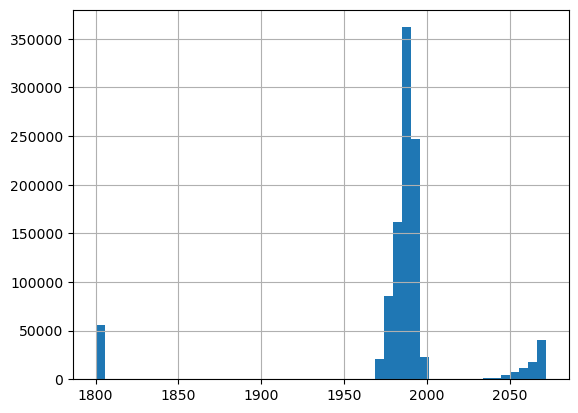

In [12]:
data.CustomerDOB = pd.to_datetime(data.CustomerDOB)             # converts to a pandas datetime object
#data.TransactionDate = pd.to_datetime(data.TransactionDate)    # NOT NEEDED
#data.TransactionTime = (data.TransactionTime.apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S'))).dt.time

data.CustomerDOB.dt.year.hist(bins=50);

(984074, 11)


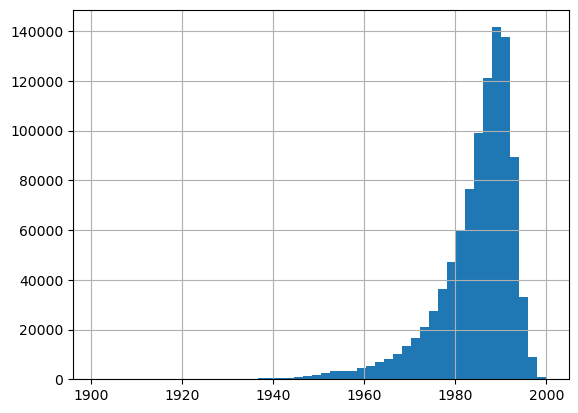

In [13]:
data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)
data.drop(data[data.CustomerDOB.dt.year == 1800].index, axis=0, inplace=True)

data.CustomerDOB.dt.year.hist(bins=50);
print(data.shape)                                  # (984074, 11)

Finally, instead of considering the exact day of birth of people, we take their age:

In [14]:
data['CustomerAge'] = (( pd.to_datetime('today') - data.CustomerDOB ) / np.timedelta64(1, 'Y')).round(0)
data['CustomerAge'] = data['CustomerAge'].astype(int)

In [15]:
####
data = data.drop(['CustomerDOB','TransactionTime',"TransactionAmount (INR)","CustAccountBalance"], axis=1)
print(data.shape)
#data.to_csv("df_finale.csv")            # (984074, 8)

(984074, 8)


### 1.2 Fingerprint Hashing

In [16]:
#data = pd.read_csv("df_finale.csv",index_col=0)

print(data.shape, len(data.CustomerID) == len(set(data.CustomerID)))
data.head(4)                                                               # (984074, 8)

(984074, 8) True


,CustomerID,CustGender,CustLocation,TransactionDate,n_of_transactions,Transaction_class,AccountBalance_size,CustomerAge
0,C1010012,M,MUMBAI,14/8/16,1,1200-2399,16754-29419,29
1,C1010018,F,CHAMPARAN,15/9/16,1,0.01-60,0.01-989,33
2,C1010024,M,KOLKATA,18/8/16,1,2399-1560035,57399-150358,58
3,C1010028,F,DELHI,29/8/16,1,458-700,150359-15035495,34


The first step of [**LSH algorithm**](https://www.learndatasci.com/tutorials/building-recommendation-engine-locality-sensitive-hashing-lsh-python/) is converting documents (costumer data) to shingles.\
A shingle is the set of features that describe the customer.\
To build shingles we choose **size** of **k** equal to 1: this is the _"bag of words model"_, where each shingle element is a document's word $(k=1)$.\
In this application it is not a word, because we are not dealing with text documents, but a customer feature.

Here is an example taken from the suggested guide:
>Document_1 = "Reinforcement Learning using Augmented Neural Networks"\
>Shingle_1 = {'reinforcement', 'learning', 'using', 'augmented', 'neural', 'networks'}

More refined approaches, that consider shingles created at character-level, are possible.

We store our shingles in a dictionary.\
Dictionary **keys** are the **CustomerIDs**, while the **values** are the **set of their features** → all other columns of the dataframe


In [17]:
## Making shingles :

d = {}       
for i in tqdm(range(data.shape[0])):
    d[data.CustomerID.iloc[i]] = set(data.iloc[i][1:])  # keys are CustomerID, values are their set of features

out = list(itertools.islice(d.items(), 5))              # show first 5 lines of d

print(" ")
print(*out, sep= "\n") 
print("\n len(d) :", len(d))                      # len(d) : 984074 = total number of costumers

100%|██████████| 984074/984074 [02:45<00:00, 5936.65it/s]

 
('C1010012', {1, 'M', 'MUMBAI', '16754-29419', '1200-2399', '14/8/16', 29})
('C1010018', {1, 33, '0.01-60', 'F', '15/9/16', 'CHAMPARAN', '0.01-989'})
('C1010024', {1, 'KOLKATA', 'M', '2399-1560035', '57399-150358', '18/8/16', 58})
('C1010028', {'458-700', 1, 34, 'DELHI', 'F', '29/8/16', '150359-15035495'})
('C1010036', {1, '150359-15035495', 'M', 'GURGAON', '160-270', 27, '26/8/16'})

 len(d) : 984074


Now we **map** each (unique) element appearing in the shingles with a **unique ID** starting at 0.\
All entries that repeat multiple times in shingles are mapped to the same number.\
We save pairs in a dictionary named "vocabulary".

Then create a new dictionary that is twin to $d$, but which contains ID instead of the real feature for each costumer.\
Example:

>Shingle_1 = {'M', '1', 'MUMBAI', '458-700', '1-60', '27', '26/8/16'} 🠊  becomes 🠊 IDs_Shingle_1 = {123, 5677, 42325, 210, 97, 12, 1}

The uniqueness of the sets remain unchanged\
In new dictionary **keys** still the **CustomerIDs**, while the **values** are the **set of ID of their shingle's elements** 

In [19]:
vocabulary = {}
shingle_id_dict = {}

count = 0
for costumer_id, values in tqdm(d.items()):   # loop for key and values over a dict
    warehouse = set()                         # initialize empty set for the new dict.vales()
    for data in values:
        if data not in vocabulary.keys():     # map shingle element with increasing ID = count
            vocabulary[data] = count          # store pairs in vocabulary
            count += 1
        warehouse.add(vocabulary[data])       # build customer's set with shingle element IDs
    shingle_id_dict[costumer_id] = warehouse   # assign: key = CustomerID, values = set with shingles IDs
    
out = list(itertools.islice(vocabulary.items(), 6))    # show first lines of "Vocabulary" dict

print(" ")
for i in range(len(out)):
    print("{}  →  is the ID of shingle : '{}'".format(out[i][1],out[i][0]))
    
print("\n length Vocabulary :", len(vocabulary))    

100%|██████████| 984074/984074 [00:08<00:00, 120198.14it/s]

 
0  →  is the ID of shingle : '1'
1  →  is the ID of shingle : '14/8/16'
2  →  is the ID of shingle : '1200-2399'
3  →  is the ID of shingle : 'MUMBAI'
4  →  is the ID of shingle : '16754-29419'
5  →  is the ID of shingle : 'M'

 length Vocabulary : 8338


Let's print **customers IDs**, their Shingles set and their **Shingles ID set** :

In [20]:
d_4 = list(itertools.islice(d.items(), 4))                        # show first lines of 'd' dict
doc_4 = list(itertools.islice(shingle_id_dict.items(), 4))   # and 'shingle_id_dict' to confront them

print(" ")
for one,two in zip(d_4, doc_4):
    print("Costumer: {} = {}  →{:<2} {}".format(one[0],one[1],"", two[1])) 

 
Costumer: C1010012 = {1, '14/8/16', '1200-2399', 'MUMBAI', '16754-29419', 'M', 29}  →   {0, 1, 2, 3, 4, 5, 6}
Costumer: C1010018 = {'0.01-60', 1, 33, 'F', '0.01-989', '15/9/16', 'CHAMPARAN'}  →   {0, 7, 8, 9, 10, 11, 12}
Costumer: C1010024 = {1, '57399-150358', '18/8/16', '2399-1560035', 'M', 58, 'KOLKATA'}  →   {0, 5, 13, 14, 15, 16, 17}
Costumer: C1010028 = {1, 34, 'F', '150359-15035495', '29/8/16', 'DELHI', '458-700'}  →   {0, 9, 18, 19, 20, 21, 22}


In [21]:
#output = open("shingle_id_dict.pkl", 'wb')
#pickle.dump(shingle_id_dict, output)
#output.close()

#output = open("vocabulary.pkl", 'wb')
#pickle.dump(vocabulary, output)
#output.close()

#output = open("d.pkl", 'wb')
#pickle.dump(d, output)
#output.close()

#pklHandler = open("shingle_id_dict.pkl", 'rb')
#shingle_id_dict = pickle.load(pklHandler)
#pklHandler.close()

#pklHandler = open("vocabulary.pkl", 'rb')
#vocabulary = pickle.load(pklHandler)
#pklHandler.close()

**Query processing :**

In [22]:
from module import query_preprocess as qr

Processing query users in the same way we did for customers, with two functions imported from **module.py**
- The first function to clean the dataset and make it compatible with bank customer data 
- The second one to make shingles from query users → Same shingle IDs used for customers before

Lost four query users due to the Day Of Birthday issue

In [23]:
query = qr.upload_query()

q, q_shingle = qr.shingling_query(query, vocabulary)
print("\n length Vocabulary :", len(vocabulary))


   original_shape : (50, 7)  →  query.shape : (46, 7)

query_user: 0 = {1, '60-160', '57399-150358', 45, '2/9/16', 'M', 'DELHI'}  →   {0, 36, 5, 13, 21, 185, 31}
query_user: 1 = {1, 'PANCHKULA', '2/9/16', '2399-1560035', '4724-9729', 'M', 31}  →   {0, 34, 36, 5, 200, 42, 15}
query_user: 2 = {1, 'PATNA', '10/8/16', '4724-9729', 'M', '458-700', 31}  →   {0, 34, 5, 42, 205, 54, 22}
    ...

 length Vocabulary : 8339


**MinHash Signatures**

The second step is to build the signature matrix.\
From now on all the steps will be performed on both the query and the main documents.

**Jaccard similarity** is the measure used to determine how similar two sets are. It is defined as: &ensp; $J(A,B) = \dfrac{A \cap B}{A \cup B} $

The MinHash technique simulates the effect of $n$ random permutations of rows on the "shingle matrix" composed of $0$'s and $1$'s,\
applying $n$ hash functions $h_1$, $h_2$, . . . , $h_n$ on each Shingles IDs set.

General form of hash function is: &ensp; $ h_i(x) = Y_i*x + Z_i \mod c $ &emsp; where:
>- $Y$ and $Z$ are random integers smaller than the maximum shingle id we have assigned
>- $c$ is the next prime number of maximum shingle id we have assigned

After MinHashing, each document is represented by a list of signatures of lenght $n$ equal to the number of Hash functions we used.

**Property of MinHash:** &emsp;\
The probability that the MinHash function outputs the same signature for two sets approximates the Jaccard Similarity of those sets.

&emsp; $Pr( (h(A) =h(B) ) \approx J(A,B) $

To generate the signatures we use two functions:

 1. The first one to return two lists Y and Z of length n ( n = number of Hashes ) of random numbers in range defined above


In [24]:
def coefficenti(k: int) :   ## return a k length list of number chosen random from the sequence
    
    lista = random.sample(range(0, max_ID), k) 
    
    if len(lista) != len(set(lista)):      # make sure have unique numbers
        print("errore!")
    else:
        return lista

2. The second function is to generate minHash functions on the entire corpus of documents:

The first loop takes each set of document features: at each iteration it applies $n$ minHash functions to each element of the set.\
Performed the $H_i$ function on each element of the set, store the minimum value obtained → $min$Hash\
This is one of $n$ signatures generated for the set. Note that for each Hash function the random coefficients Z and Y change.

In [25]:
def gen_minHash(dictionary : dict, n : int ):
    
    signatures = {}
    for key in tqdm(dictionary.keys()):         # loop on the sets of the dictionary   
        this_set = dictionary[key]              # variable = set of ID features 
        warehouse = []                         
        for i in range(0, n):                   # start loop for n Hash functions 
            minimum = c + 1                     # set min above next prime 
            for item in this_set:               # apply the i Hash to each element of set
                f_h = (Z[i] * item + Y[i]) % c  # h(x) = (z*x+y) % c
                if f_h < minimum:            
                    minimum = f_h               # update the min value taken by the hash i for this set
            warehouse.append(minimum)           # store signature for hash i 
        signatures[key] = warehouse             # store signatures for each set
        
    return signatures

In [26]:
def J_sim (set1,set2):
    result = len(set1.intersection(set2))/len(set1.union(set2))
    return result

**HOW TO CHOOSE THE NUMBER OF HASH FUNCTIONS ?**

The number of Hash functions to perform is given by two parameters: **b** and **r**. 

$b$ → is the number of $bands$ we  will divide our signature matrix into\
$r$ → is the number of $rows$ for bands: each band has the same number of rows

&emsp; $numHashes = b*r $

By changing these parameters, changes the probability that two sets with a given Jaccard similarity end up in the same bucket.

We can write this relation as a function parametrized by b and r: &emsp;  $ f_{b,r}(\text{Jac})=1−(1−\text{Jac}^r)^b. $

Corresponding Threshold is &ensp; → &ensp; $ t = \frac{1}{b}^{1/r}$


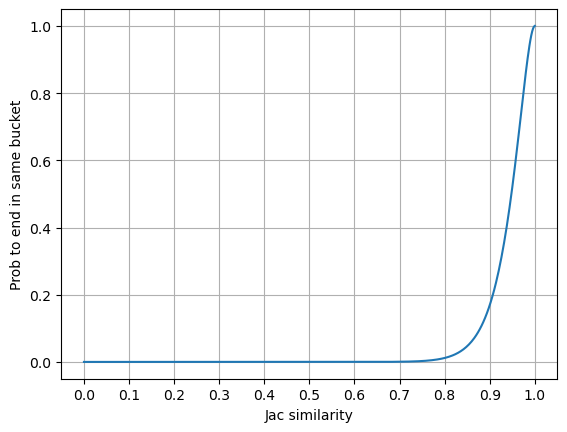


Items with Jaccard similarity = 0.85 have 0.05 % chance of ending up in the same bucket
 Threshold should be :  0.97
Number of minHash needed → 46 → rows of Signature Matrix


In [27]:
r, b = 23, 2
qr.my_f(b,r)

print("Number of minHash needed →", b*r, "→ rows of Signature Matrix")

In [28]:
nHashes = b*r

max_ID = len(vocabulary)       # max id in shingle elements   
c =  8353                      # our next prime number after max_ID                   

Z = coefficenti(nHashes)       # n random coefficients Z for n hash functions
Y = coefficenti(nHashes)       # n random coefficients Y for n hash functions

q_signatures = gen_minHash(q_shingle, nHashes)        # generate signatures
signatures = gen_minHash(shingle_id_dict, nHashes)

100%|██████████| 984074/984074 [01:20<00:00, 12171.83it/s]


Here are printed the first key and value pairs of the signatures dictionary we built : \
Each of these arrays is to be considered as a column of the **Signature Matrix**.\
Signature Matrix has number of **rows** equal to $n$ the number of minHash functions executed (permutations),\
and number of **columns** equal
to the **total amount of documents** → in our case 984074 customers


In [29]:
out = list(itertools.islice(signatures.items(), 3))        # show three entries for signature dict
for i in range(len(out)):
    print(" {}  :  {}  → lenght of signatures = {}\n".format(out[i][0],out[i][1][:56],len(out[i][1])))

 C1010012  :  [2902, 361, 7060, 116, 528, 1318, 184, 91, 208, 1480, 324, 1210, 1216, 431, 1311, 893, 4698, 897, 910, 1335, 683, 976, 1501, 2471, 252, 1225, 916, 837, 4688, 202, 607, 1491, 382, 103, 167, 129, 780, 5239, 97, 33, 693, 1121, 450, 459, 919, 288]  → lenght of signatures = 46

 C1010018  :  [418, 633, 5818, 116, 37, 1720, 1320, 293, 617, 384, 1450, 2755, 45, 3407, 1184, 192, 287, 897, 327, 1172, 1157, 98, 782, 1406, 252, 237, 871, 4, 4688, 377, 2023, 514, 382, 1034, 650, 129, 1580, 5011, 2103, 710, 1444, 684, 1985, 959, 62, 1454]  → lenght of signatures = 46

 C1010024  :  [2147, 1682, 4783, 116, 856, 170, 331, 1266, 1026, 825, 324, 381, 529, 262, 1057, 741, 2039, 482, 1298, 1009, 150, 541, 63, 696, 252, 1472, 826, 837, 58, 1268, 381, 693, 382, 478, 167, 129, 129, 4821, 767, 1387, 670, 247, 811, 459, 3810, 386]  → lenght of signatures = 46



In [30]:
out = list(itertools.islice(q_signatures.items(), 2))           # same for query users
for i in range(len(out)):
    print("{} : {} \n  → lenght of signatures = {}\n".format(out[i][0],out[i][1],len(out[i][1])))

0 : [3121, 323, 850, 116, 856, 2122, 1741, 1266, 676, 611, 324, 582, 1294, 1919, 1311, 40, 1570, 897, 520, 2812, 1631, 549, 285, 2210, 252, 1472, 691, 837, 934, 902, 750, 1051, 382, 297, 167, 129, 129, 4099, 767, 1304, 624, 379, 585, 57, 302, 484] 
  → lenght of signatures = 46

1 : [977, 400, 314, 115, 202, 974, 1741, 2239, 2194, 449, 324, 2240, 1294, 1006, 1311, 437, 415, 897, 520, 194, 150, 549, 285, 1448, 252, 686, 691, 837, 3781, 313, 418, 74, 382, 478, 167, 129, 780, 3871, 1774, 2590, 624, 1121, 1533, 57, 302, 871] 
  → lenght of signatures = 46



Building the actual **Signature Matrix**, both for bank customers and query users with numpy arrays:

In [31]:
d_matrix = np.array(list(signatures.values())).T
print("\n Signature Matrix shape : {} = (nHashes x #sets)".format(d_matrix.shape))

q_matrix = np.array(list(q_signatures.values())).T
print("Query Signature Matrix shape : {} = (nHashes x #queries)".format(q_matrix.shape))


 Signature Matrix shape : (46, 984074) = (nHashes x #sets)
Query Signature Matrix shape : (46, 46) = (nHashes x #queries)


In [32]:
c, ind_dic = 0, {}               ## N.B.
for key in signatures.keys():   ## we will need 'ind_dic' in order to retrieve customer data 
    ind_dic[c] = key           ## previously index was costumer_ID → keys of a dict
    c+=1                      ## now index is column position from 0 to 984073

### 1.3 Locality Sensitive Hashing

So we got the signature matrix, next step is divide it in bands.\
We have already chosen $\text{b}=2$ and $\text{r} = 22$ when constructing the matrix.

For each band we look at each column.\
Note that each column consists of $r$ signatures which together are to be considered as one "whole" signature of the set.\
If, for two columns of the band, the $r$ signatures match  → we consider the two sets as candidate pairs.\
We store the overall signature as a key in a dictionary, and the position (→ index of the column) as a value.\
This dictionary is the **bucket** where similar objects end up, plus note that are needed different dictionaries-buckets for each different bands

Huge source of understanding for this step has been this [**page**](https://giorgi.tech/blog/locality-sensitive-hashing), credits also for the below function implemented with **Collections.defaultDict** module :

In [33]:
def do_buckets(matrix, b):
    
    bands = np.split(matrix, b)             # split matrix along axis 0 to make bands
    buckets = []                            # empty list where to store buckets (of type collections.defaultdict)
    for band in tqdm(bands):
        items_buckets = defaultdict(list)              # initialize empty defaultdict
        items = np.hsplit(band, matrix.shape[1])       # for each band split it into its columns (along axis 1)
        for i, item in enumerate(items):               # enumerate to retrieve column position to use it as dict value
            item = tuple(item.flatten().astype(int))   # reshape signature array into one dimension
            items_buckets[item].append(i)              # assign signature to dictionary key and position as dict value
        buckets.append(items_buckets)
    return buckets

domande = do_buckets(q_matrix, b)
risposte = do_buckets(d_matrix, b)

100%|██████████| 2/2 [00:17<00:00,  8.59s/it]


In [39]:
results = {}

for i in tqdm(range(len(domande))):
    for key in domande[i]:
        if key in risposte[i]:
            if domande[i][key][0] not in results:
                results[domande[i][key][0]] = risposte[i][key]
            elif domande[i][key][0] in results:
                results[domande[i][key][0]] += risposte[i][key]
        else:
            results[domande[i][key][0]] = []
            
results = dict(zip(list(results.keys()), [set(name) if len(name)!=0 else None for name in list(results.values())]))

stringa = " → No similar clients found"
listaa = [(x,list(k)) if isinstance(k, set) else (x,stringa) for x,k in results.items()]

my_df  = pd.DataFrame([[x[0] for x in listaa], [x[1] for x in listaa]], index=['Query', 'ID_of_Similar']).T
display(my_df)


100%|██████████| 2/2 [00:00<00:00, 2052.01it/s]


,Query,ID_of_Similar
0,0,[188684]
1,1,[192720]
2,2,[618278]
3,3,[239646]
4,4,[737331]
5,5,[274830]
6,6,[177739]
7,7,[41571]
8,8,[869350]
9,9,[765618]


Below are shown the **results obtained**.\
We got the query user indexes and the bank customer indexes of those people who have been considered similar,\
we want to retrieve their information to evaluate them with true Jaccard similarity\
Bank customer data is stored in previously created **$d$ dict** and query data is stored in **$q$ dict**

The computation is done through the _retrive_similar_ function taken from **module.py**\
For a query index input, returns CostumerID and features of people that match the query.\
To do this, we used a "_bridge_" dictionary to map index in Signature Matrix to costumerID in $d$ 

In [35]:
from module import get_silimilar

gt = get_silimilar()

In [36]:
print("*"*100)
for i in range(len(results)):
    gt.retrive_similar(results, q, d, i, ind_dic)
    print("\n"+"*"*100+"\n")

****************************************************************************************************
Query user : 0 → {1, '60-160', '57399-150358', 45, '2/9/16', 'M', 'DELHI'}

Found similarity with :

   C3167055 {1, '60-160', '57399-150358', 45, '2/9/16', 'M', 'DELHI'}  with J_sim = 1.0

****************************************************************************************************

Query user : 1 → {1, 'PANCHKULA', '2/9/16', '2399-1560035', '4724-9729', 'M', 31}

Found similarity with :

   C3224067 {1, 'PANCHKULA', '2/9/16', '2399-1560035', '4724-9729', 'M', 31}  with J_sim = 1.0

****************************************************************************************************

Query user : 2 → {1, 'PATNA', '10/8/16', '4724-9729', 'M', '458-700', 31}

Found similarity with :

   C8138931 {1, 'PATNA', '10/8/16', '4724-9729', 'M', '458-700', 31}  with J_sim = 1.0

****************************************************************************************************

Query user 

### Comments on the results:

The goal was to find customers as similar as possible to the query users, so we built the signature matrix by choosing\
the number of $bands$ and related $rows$ in order to have a threshold of 97%.\
We succeeded and with these parameters of $b$ and $r$ we found few matches per query but with a very high similarity.\
Most of the results have a **Jaccard Similarity** of exactly $1$ to their query.\
This is due to the data preparation stage, where we have transformed two festures into categorical variables : 'TransactionAmount' and 'CustAccountBalance'.\
Furthermore, instead of considering the exact day of birth of people, we have taken their age.

About 10 people in the query didn't find any match, but this should be okay.\
Looking deeper in the dataset, none of them have high similarity (_> 0.765_) with the bank's customers.

By lowering the threshold value we find more results per query but they have a larger distance from it.\
In particular we find many more clients with a jaccard similarity of _0.75_ with the query. It means that these share 6 out of 7 items with the query.


In [37]:
# Checking J similarity for query_users: 

big = []
for j in tqdm(q.keys()):
    lista = []
    for i in d.values():
        result = J_sim(i, q[j])
        if result > 0.765:
            lista.append(result)
    big.append(lista)
print(big)                  # empty list where there are no matches → this confirms LSH results for users not found

100%|██████████| 46/46 [00:57<00:00,  1.26s/it]

[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0, 1.0, 1.0, 1.0], [1.0], [1.0], [1.0], [1.0], [1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0], [1.0], [1.0, 1.0], [1.0], [1.0], [1.0, 1.0], [1.0], [1.0, 1.0, 1.0, 1.0], [1.0], [1.0], [1.0, 1.0], [1.0], [1.0, 1.0, 1.0], [], [1.0, 1.0], [1.0], [], [], [], [], [], [], [], [1.0], [], [], [], [1.0]]


## **2. Grouping customers together!**

## 2.1 Getting your data + feature engineering

In this step known as ***feature engineering*** we want to create new features starting from our datas.\
As recommended we create a new dataframe with all the new features groupped by CustomerID.

In [37]:
data = pd.read_csv("https://myasw2009bucket.s3.amazonaws.com/HW4_bank_LSH.zip")  # re-load the dataset from AWS S3

#data= pd.read_csv("bank_transactions.csv")                                 # re-load the dataset
data=data.rename(columns={'TransactionAmount (INR)':'TransactionAmount'})  # rename TransactionAmount (INR) for easier use
data.dropna(inplace=True)                                                  # delete rows with nan values

data.CustomerDOB=pd.to_datetime(data.CustomerDOB)            # transform CustomerDOB and TransactionDate into datetime type
data.TransactionDate=pd.to_datetime(data.TransactionDate)
data.TransactionTime=(data.TransactionTime.apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S'))).dt.time

# correct mistake on the dates of Bday:
data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] = data.loc[data.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)
data.drop(data[data.CustomerDOB.dt.year == 1800].index, axis=0, inplace=True)
#data.CustomerDOB.dt.year.hist(bins=50)

data.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,14:32:07,25.0
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,14:18:58,27999.0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,14:27:12,459.0
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,14:27:14,2060.0
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,18:11:56,1762.5


In [38]:
#we create a column with all the transactions with a balance bigger than 100 USD

data['Trans100'] = data.loc[data['TransactionAmount'] >100 , 'TransactionAmount']

In [39]:
#we create a column with the average difference between the balance and the transaction amount for each customer

data['Utilisation'] = data['CustAccountBalance'] - data['TransactionAmount']

In [40]:
##we create a column with the customer age

data['CustomerAge'] = (( pd.to_datetime('today') - data.CustomerDOB ) / np.timedelta64(1, 'Y')).round(0)
data['CustomerAge'] = data['CustomerAge'].astype(int)

In [41]:
#we create a column with only the account balance bigger then 100000 to obtain the wealthier customers

data['Balance100000'] = data.loc[data['CustAccountBalance'] >100000 , 'CustAccountBalance']

In [42]:
# we create a column with day of the week setted with a number from 0 to 6 to obtain the day 
# on which the customer makes most transactions

data['day_week'] = data.TransactionDate.dt.day_of_week

In [43]:
# we create a column with months setted with a number from 0 to 11 to obtain the month 
# in which the customer on average makes more transactions

data['month'] = data.TransactionDate.dt.month

In [44]:
data['CustomerDOB1'] = data['CustomerDOB'].dt.strftime('%m-%d')
data['TransactionDate1'] = data['TransactionDate'].dt.strftime('%m-%d')

In [45]:
#we create this column because we want to obtain the transaction amount on the birthday

data['birthday'] = data.loc[data['TransactionDate1'] == data['CustomerDOB1']].TransactionAmount

In [46]:
#we want to know the number of transaction was during the weekend

data['weekend'] = data.loc[(data['day_week'] ==5) | (data['day_week'] ==6) , 'day_week']

In [47]:
#we want to know the number of transaction was during the summer and winter

data['summer'] = data.loc[(data['month']==6) | (data['month']==7) | (data['month']==8) | (data['month']==9), 'month']
data['winter'] = data.loc[(data['month']==11) | (data['month']==12) | (data['month']==1) | (data['month']==2) | (data['month']==3), 'month']

In [48]:
#in order to know the how many transaction in lunch and dinner time for each customers

data['TransTime'] = [int(i.strftime("%H")) for i in data['TransactionTime'] ]
data['time_lunch'] = data.loc[(data['TransTime'] ==12) | (data['TransTime'] == 13) | (data['TransTime'] == 14) | (data['TransTime'] == 15) , 'TransTime']
data['time_dinner'] = data.loc[(data['TransTime'] ==19) | (data['TransTime'] == 20) | (data['TransTime'] == 21) | (data['TransTime'] == 18) , 'TransTime']

In [49]:
#in order to find the richer females

data['richer_F'] = data.loc[(data['CustGender'] =='F') & (data['CustAccountBalance'] > 15000000) , 'CustAccountBalance']

In [50]:
#in order to find the richer males

data['richer_M'] = data.loc[(data['CustGender'] =='M') & (data['CustAccountBalance'] > 15000000) , 'CustAccountBalance']

In [51]:
#we want to know the older people

data['older'] = data.loc[(data['CustomerAge'] > 80) , 'CustAccountBalance']

In [52]:
#we want the percentage of the richer people

data['percentage_bal'] = (data['Balance100000'] / data['Balance100000'].sum()) * 100

In [53]:
#we want the percentage of the transaction 

data['percentage_trans'] = (data['TransactionAmount'] / data['TransactionAmount'].sum()) * 100

In [54]:
#we want all the transaction in Mumbai

data['Mumbai_trans'] = data.loc[(data['CustLocation']=='MUMBAI'), 'TransactionAmount']

In [55]:
dataframe={'CustomerID': list(np.unique(data.CustomerID)),
           'n_transactions':list(data.groupby('CustomerID').TransactionID.count()),
           'trans100':list(data.groupby('CustomerID').Trans100.count()),
           'ave_transaction':list(data.groupby('CustomerID').TransactionAmount.mean()),
           'ave_balance':list(data.groupby('CustomerID').CustAccountBalance.mean()),
           'ave_utilisation':list(data.groupby('CustomerID').Utilisation.mean()),
           'common_gender':list(data.groupby('CustomerID').CustGender.max()),
           'common_location':list(data.groupby('CustomerID').CustLocation.max()),
           'cust_age':list(data.groupby('CustomerID').CustomerAge.mean()),
           'balance100000':list(data.groupby('CustomerID').Balance100000.count()),
           'day_week':list(data.groupby('CustomerID').day_week.max()),
           'ave_month':list(data.groupby('CustomerID').month.mean()),
           'lunch_time': list(data.groupby('CustomerID').time_lunch.count()),
           'dinner_time': list(data.groupby('CustomerID').time_dinner.count()),
           'older': list(data.groupby('CustomerID').older.count()),
           'birthday_amount':list(data.groupby('CustomerID').birthday.median()),
           'min_trans':list(data.groupby('CustomerID').TransactionAmount.min()),
           'min_balance':list(data.groupby('CustomerID').CustAccountBalance.min()),
           'diff_interquantile_b':list(data.groupby('CustomerID').CustAccountBalance.quantile(0.75)-data.groupby('CustomerID').CustAccountBalance.quantile(0.25)),
           'weekend':list(data.groupby('CustomerID').weekend.count()),
           'summer': list(data.groupby('CustomerID').summer.count()),
           'winter': list(data.groupby('CustomerID').winter.count()),
           'thirdq_trans':list(data.groupby('CustomerID').TransactionAmount.quantile(0.75)),
           'richer_f':list(data.groupby('CustomerID').richer_F.max()),
           'richer_m':list(data.groupby('CustomerID').richer_M.max()),
           'percentage_b':list(data.groupby('CustomerID').percentage_bal.max()),
           'percentage_t':list(data.groupby('CustomerID').percentage_trans.max()),
           'mumbai_trans':list(data.groupby('CustomerID').Mumbai_trans.mean())
           }

In [56]:
df = pd.DataFrame(dataframe)   # create the dataframe

In [57]:
df['birthday_amount'] = df['birthday_amount'].fillna(0)
df['richer_f'] = df['richer_f'].fillna(0)
df['richer_m'] = df['richer_m'].fillna(0)
df['percentage_b'] = df['percentage_b'].fillna(0)
df['percentage_t'] = df['percentage_t'].fillna(0)
df['mumbai_trans'] = df['mumbai_trans'].fillna(0)

In [58]:
print("df.shape :", df.shape)
df.head()

df.shape : (839081, 28)


,CustomerID,n_transactions,trans100,ave_transaction,ave_balance,ave_utilisation,common_gender,common_location,cust_age,balance100000,...,diff_interquantile_b,weekend,summer,winter,thirdq_trans,richer_f,richer_m,percentage_b,percentage_t,mumbai_trans
0,C1010011,2,2,2553.0,76340.635,73787.635,M,NOIDA,35.0,1,...,43839.905,0,2,0,3651.50,0.0,0.0,0.000137,0.000332,0.0
1,C1010012,1,1,1499.0,24204.490,22705.490,M,MUMBAI,29.0,0,...,0.000,1,1,0,1499.00,0.0,0.0,0.000000,0.000105,1499.0
2,C1010014,2,2,727.5,100112.950,99385.450,M,MUMBAI,34.5,1,...,61735.810,0,1,1,966.25,0.0,0.0,0.000184,0.000084,727.5
3,C1010018,1,0,30.0,496.180,466.180,F,CHAMPARAN,33.0,0,...,0.000,0,1,0,30.00,0.0,0.0,0.000000,0.000002,0.0
4,C1010024,1,1,5000.0,87058.650,82058.650,M,KOLKATA,58.0,0,...,0.000,0,1,0,5000.00,0.0,0.0,0.000000,0.000349,0.0


## 2.2 Choose your features (variables)!

Our goal now is to reduce the dimentionality of our dataframe and hopefully understand the data better. For doing that we choose PCA method.\
It can be applied in high-dimentional data and it is easy to compute.\
The disadvantages of the pca are the loss of informations and the low interpretability of the principal components because they are linear combinations of the features from the original data.

First of all we have to convert our categorial variables in numerical, in order to do it we assigne to each value an identificative number.

In [59]:
df['common_gender'].replace(['M', 'F'], [0, 1], inplace=True)

In [60]:
df['common_location'] = pd.factorize(df['common_location'])[0]

In [61]:
print("df.shape :", df.shape)
df.head()

df.shape : (839081, 28)


,CustomerID,n_transactions,trans100,ave_transaction,ave_balance,ave_utilisation,common_gender,common_location,cust_age,balance100000,...,diff_interquantile_b,weekend,summer,winter,thirdq_trans,richer_f,richer_m,percentage_b,percentage_t,mumbai_trans
0,C1010011,2,2,2553.0,76340.635,73787.635,0,0,35.0,1,...,43839.905,0,2,0,3651.50,0.0,0.0,0.000137,0.000332,0.0
1,C1010012,1,1,1499.0,24204.490,22705.490,0,1,29.0,0,...,0.000,1,1,0,1499.00,0.0,0.0,0.000000,0.000105,1499.0
2,C1010014,2,2,727.5,100112.950,99385.450,0,1,34.5,1,...,61735.810,0,1,1,966.25,0.0,0.0,0.000184,0.000084,727.5
3,C1010018,1,0,30.0,496.180,466.180,1,2,33.0,0,...,0.000,0,1,0,30.00,0.0,0.0,0.000000,0.000002,0.0
4,C1010024,1,1,5000.0,87058.650,82058.650,0,3,58.0,0,...,0.000,0,1,0,5000.00,0.0,0.0,0.000000,0.000349,0.0


* To normalise or not to normalise? 

In order to apply the PCA method the normalization is essential beacuse PCA is effected by scale so we need to scale the features in our dataframe before applying PCA.\
To convert dataset’s features onto unit scale, we choose the standardization method : 

<p align="center">
<img src="https://cdn-images-1.medium.com/max/512/1*Ap_7t_-luGSaAVgc7kl7qA.png" alt="drawing" width="150"/>
</p>

Otherwise variables with larger ranges will dominate over those with small ranges, which will lead to biased results.\
We will be using scikit-learn’s StandardScaler as the feature matrix is a mix of binary and continuous features 


In [62]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 
import seaborn as sns

In [63]:
features = ['n_transactions', 'trans100', 'ave_transaction', 'ave_balance', 'ave_utilisation', 'common_gender', 
            'common_location', 'cust_age', 'balance100000', 'day_week', 'ave_month', 'lunch_time', 'dinner_time',
            'older', 'birthday_amount','min_trans', 'min_balance', 'diff_interquantile_b','weekend','summer', 'winter', 
            'thirdq_trans', 'richer_f', 'richer_m', 'percentage_b', 'percentage_t', 'mumbai_trans']

x = df.loc[:, features].values

# Standardizing the features
x = StandardScaler().fit_transform(x)
stand_df=pd.DataFrame(x, columns=features)

In [68]:
print("\nstand_df.shape :", stand_df.shape, "\n")
stand_df.head()


stand_df.shape : (839081, 27) 



,n_transactions,trans100,ave_transaction,ave_balance,ave_utilisation,common_gender,common_location,cust_age,balance100000,day_week,...,diff_interquantile_b,weekend,summer,winter,thirdq_trans,richer_f,richer_m,percentage_b,percentage_t,mumbai_trans
0,1.897629,1.906793,0.181860,-0.037537,-0.038951,-0.569962,-0.359820,-0.311102,2.003372,-0.092568,...,0.129293,-0.667981,2.098239,-0.554166,0.338292,-0.00598,-0.015186,0.018846,0.469705,-0.080704
1,-0.400541,0.102428,0.007506,-0.103847,-0.103946,-0.569962,-0.358648,-1.007802,-0.467304,1.424192,...,-0.063972,1.305014,0.400151,-0.554166,-0.006057,-0.00598,-0.015186,-0.117375,-0.020811,0.556825
2,1.897629,1.906793,-0.120116,-0.007302,-0.006381,-0.569962,-0.358648,-0.369160,2.003372,0.413019,...,0.208185,-0.667981,0.400151,1.649069,-0.091285,-0.00598,-0.015186,0.066076,-0.065171,0.228704
3,-0.400541,-1.701937,-0.235497,-0.134001,-0.132242,1.754502,-0.357476,-0.543335,-0.467304,-0.092568,...,-0.063972,-0.667981,0.400151,-0.554166,-0.241062,-0.00598,-0.015186,-0.117375,-0.242457,-0.080704
4,-0.400541,0.102428,0.586644,-0.023906,-0.028427,-0.569962,-0.356303,2.359583,-0.467304,-0.092568,...,-0.063972,-0.667981,0.400151,-0.554166,0.554019,-0.00598,-0.015186,-0.117375,0.507426,-0.080704


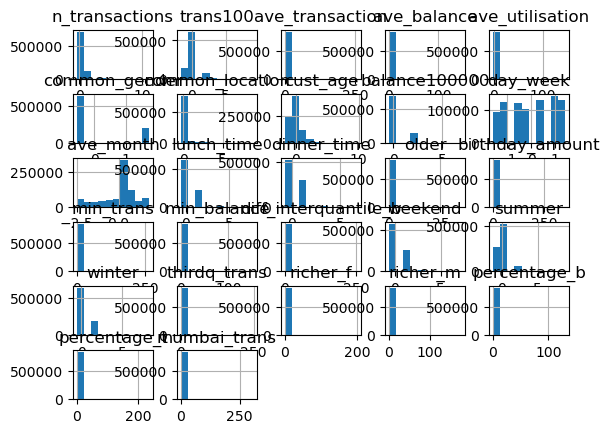

In [69]:
stand_df.hist()
plt.show()

We study the relationship between variables because if they are strongly correlated it means that they contain redundant information.

In [70]:
cor = stand_df.corr(method='pearson')

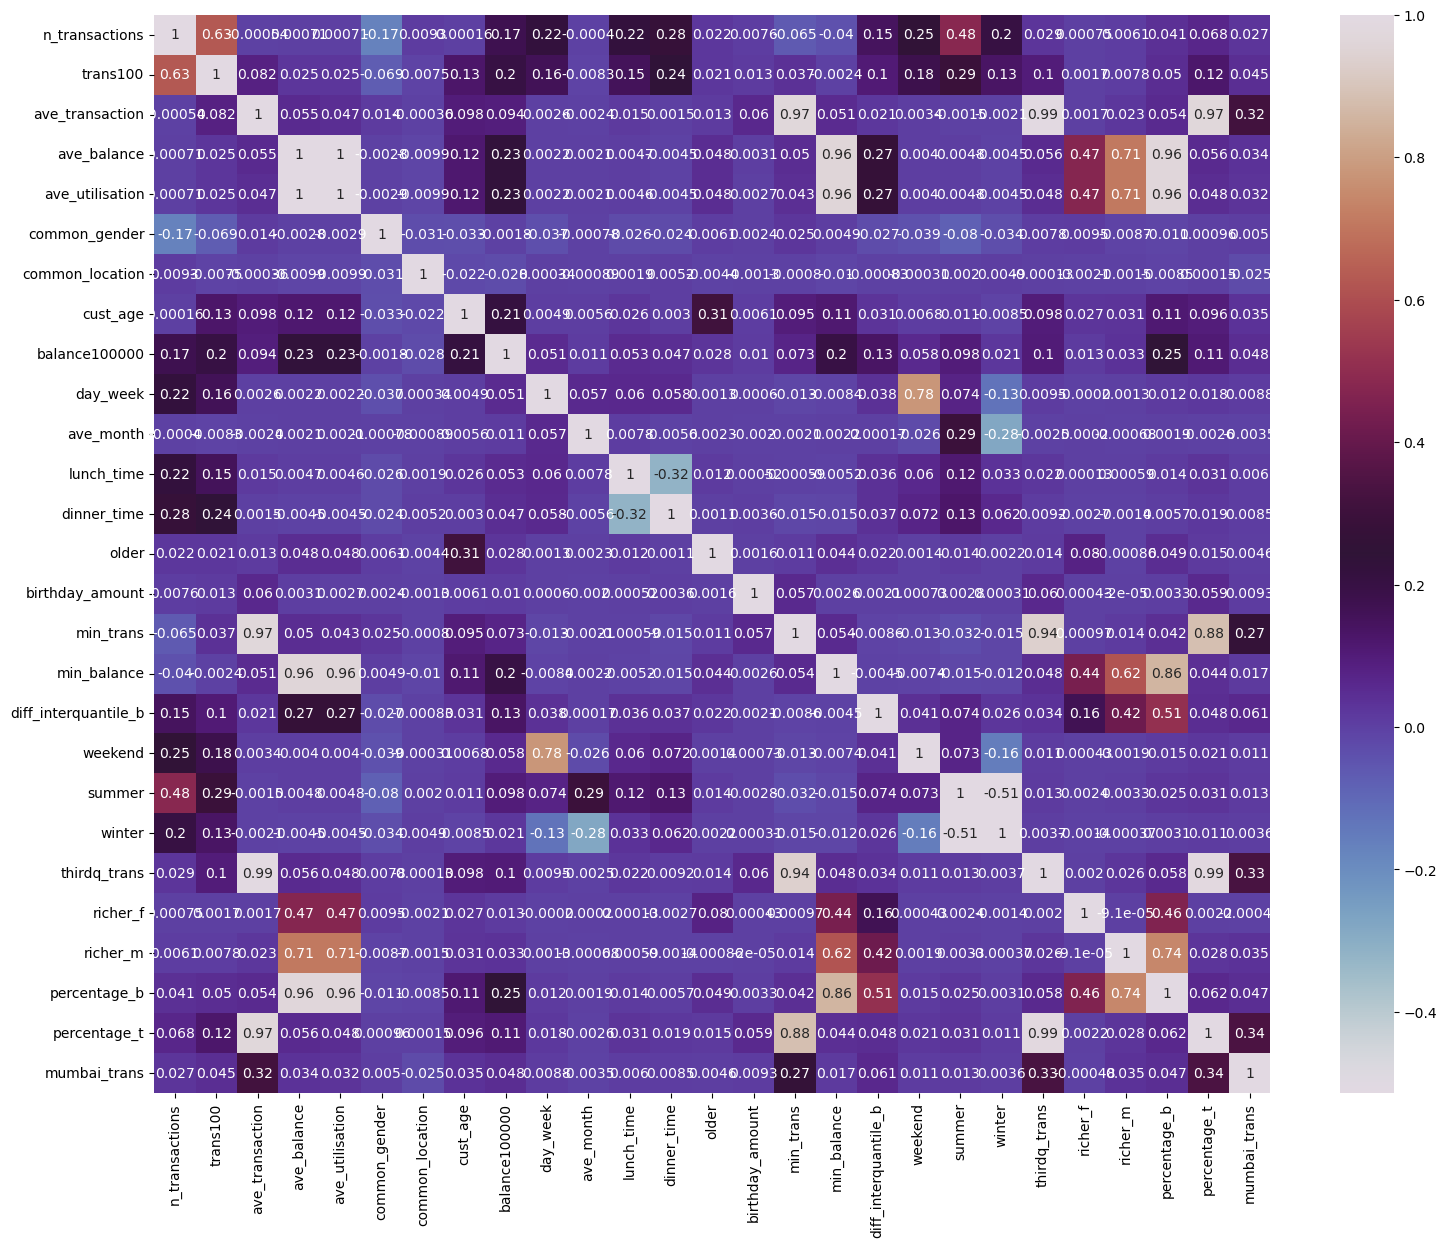

In [71]:
plt.figure(figsize=(18,14))
sns.heatmap(cor, cmap="twilight",annot=True)
plt.show()

***Pearson's correlation coefficients*** is in the interval [-1, 1]. 
* -1 if the variables are perfect negative correlated.
* 0 if the are not correlated at all.
* 1 if the variables are perfect positive correlated.

We prefer values in the interval [0.3, -0.3] because his strength is weak.
Our variable are in general almost entirely unrelated in fact their values are near to 0. Only some of them are strongly correlated with other variables so we decide to delete trans100, weekend, summer, ave_transaction, ave_balance, ave_utilisation, min_trans, min_balance, diff_interquantile_b, thirdq_trans and percentage_b.

We can plot some examples of strongly positive correlated:

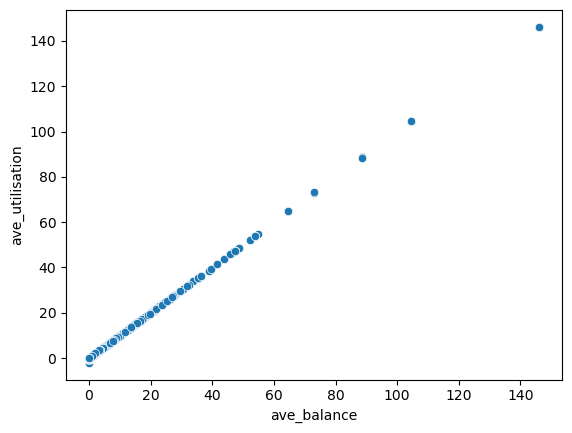

In [73]:
sns.scatterplot(x=stand_df.ave_balance, y=stand_df.ave_utilisation);

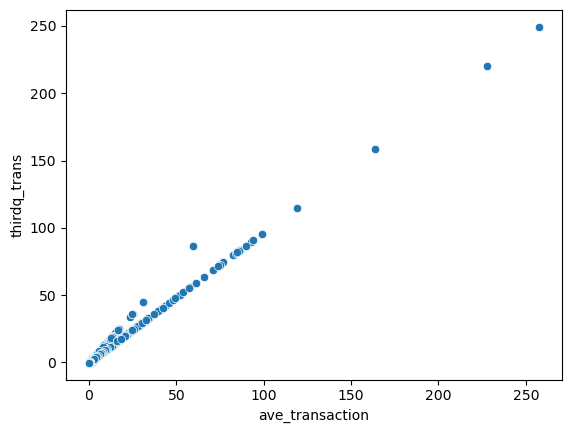

In [74]:
sns.scatterplot(x=stand_df.ave_transaction, y=stand_df.thirdq_trans);

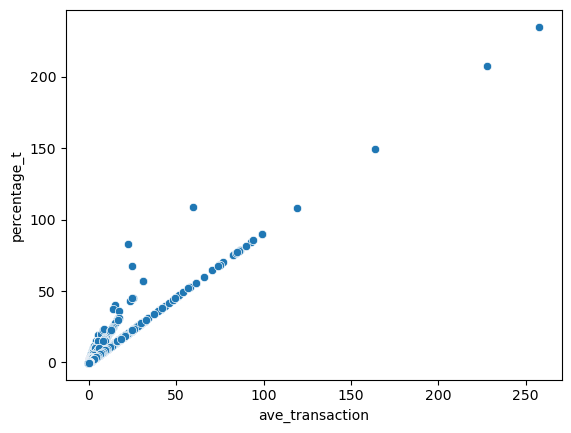

In [75]:
sns.scatterplot(x=stand_df.ave_transaction, y=stand_df.percentage_t);

In [76]:
stand_df.drop(['trans100', 'weekend', 'summer', 'ave_transaction', 'ave_balance', 'ave_utilisation',
               'min_trans', 'min_balance', 'diff_interquantile_b', 'thirdq_trans',  'percentage_b'], axis=1, inplace=True)

In [77]:
features = ['n_transactions',  'common_gender', 'common_location', 'cust_age', 'balance100000', 
            'day_week', 'ave_month', 'lunch_time', 'dinner_time', 'older', 'birthday_amount',
            'winter',  'richer_f', 'richer_m', 'percentage_t', 'mumbai_trans']

x = stand_df.loc[:, features].values

# Standardizing the features
x = StandardScaler().fit_transform(x)
stand_DF=pd.DataFrame(x, columns=features)

In [78]:
cor = stand_DF.corr(method='pearson')

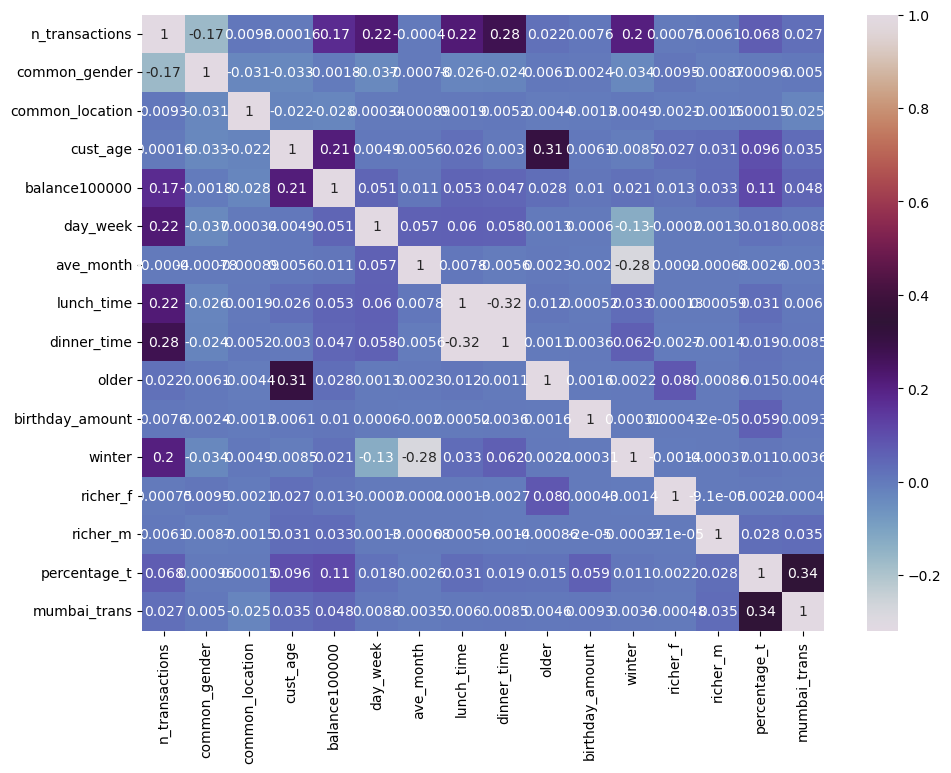

In [79]:
plt.figure(figsize=(11,8))
sns.heatmap(cor, cmap="twilight",annot=True)
plt.show()

In order to choose the number of the ***principal components*** we have to compute the ***eigenvalues*** and eigenvectors on the covariance matrix. Principal components are new variables that are constructed as linear combinations or mixtures of the initial variables. These combinations are done in such a way that the new variables are uncorrelated and most of the information is in the first components.  In this way we can reduce our datas without losing information.

In [80]:
pca = PCA(n_components=16)            # create the number of components as the features of our dataframe
PC = pca.fit_transform(stand_DF)
PC_Df = pd.DataFrame(data = PC
             , columns = ['pc1', 'pc2','pc3','pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 
                          'pc10', 'pc11', 'pc12', 'pc13', 'p14', 'p15', 'p16'])

* The first approach to selecting the number of principal components is the ***elbow method*** and we use the scree plot. It shows the number of components on the X-axis against the proportion of the variance explained on the Y-axis. The suggested number of components to keep is where the plot forms an elbow and the curve flattens out.

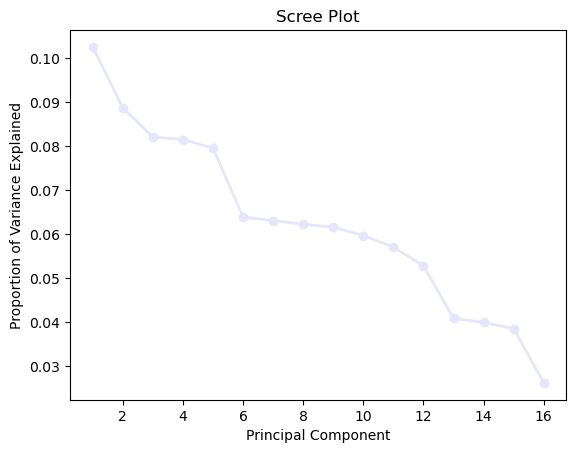

In [81]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2, color='lavender')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

From this plot the number of principal components shuold be 6. But this is not the most accurate approach. 

* We can consider the ***Kaiser rule*** : the number of principal components to keep is equal to the number of eigenvalues greater than 1.

In [82]:
print(pca.explained_variance_)

[1.64059846 1.41775033 1.3136294  1.30389381 1.27190034 1.02174507
 1.00940968 0.99593438 0.98490589 0.95493031 0.91265112 0.84479557
 0.65346618 0.6388984  0.61654051 0.41896961]


From the eigenvalues values we will consider the first 7principal components

* The third approach regards the ***variation*** in the data: keep as many principal components as needed to explain at least 70% of the total variance.

In [83]:
print ("Proportion of Variance Explained : ", pca.explained_variance_ratio_)  
    
out_sum = np.cumsum(pca.explained_variance_ratio_)  
print ("Cumulative Prop. Variance Explained: ", out_sum)

Proportion of Variance Explained :  [0.10253728 0.08860929 0.08210174 0.08149327 0.07949368 0.06385899
 0.06308803 0.06224582 0.06155654 0.05968307 0.05704063 0.05279966
 0.04084159 0.0399311  0.03853374 0.02618557]
Cumulative Prop. Variance Explained:  [0.10253728 0.19114657 0.27324831 0.35474158 0.43423525 0.49809424
 0.56118227 0.6234281  0.68498464 0.74466772 0.80170835 0.85450801
 0.89534959 0.9352807  0.97381443 1.        ]


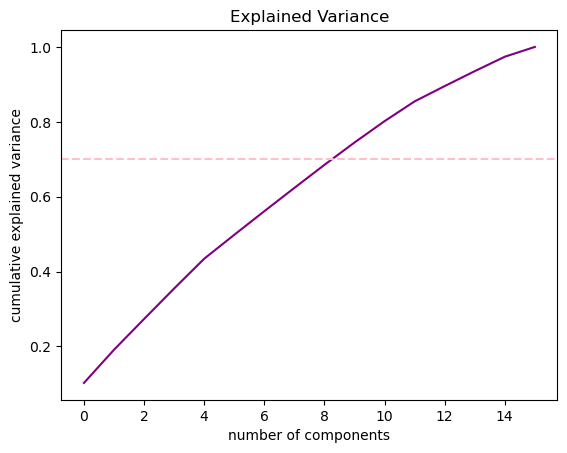

In [84]:
plt.plot(out_sum, color='purple')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Explained Variance')
plt.axhline(0.7,color='pink', linestyle='--')
plt.show()

Also from this other approach the right number of principal components is 9 because they explain 70% of the total variance.
This solution is what we were looking for.

In [85]:
pca1 = PCA(n_components=9)
PCA = pca1.fit_transform(stand_DF)
PCA_DF = pd.DataFrame(data = PCA
             , columns = ['pc1', 'pc2','pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9'])

In [86]:
PCA_DF

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9
0,1.831368,0.334847,-1.541369,-1.319367,0.313956,-0.690939,-0.096396,0.170045,-0.023460
1,-0.122572,-0.570520,-0.954031,1.405849,0.635203,0.083004,0.266145,-0.396721,0.146749
2,2.387315,-1.243865,0.113743,-2.403769,0.096613,-0.920115,0.072346,0.014228,0.099307
3,-1.460044,0.764771,-0.115957,0.414500,0.325475,-0.788221,0.448606,-0.156811,0.234614
4,0.569600,1.822203,-0.232643,-1.111460,-0.480007,0.170027,-0.292326,0.219537,-0.420036
...,...,...,...,...,...,...,...,...,...
839076,0.118552,0.365122,-0.447377,0.094602,0.023304,-0.599925,-0.294354,0.226066,0.014905
839077,-0.921338,0.303826,-1.158681,-1.252872,0.702233,0.091755,0.120670,-0.177367,0.172731
839078,-0.795571,0.298068,-0.924318,-1.344685,0.539487,0.330434,0.029889,-0.126340,0.109529
839079,-0.411848,-0.815851,-1.141379,1.295722,0.240025,0.011942,0.246884,-0.269499,0.224285


## 2.3 Clustering!

In order to use the k-means algorithm we choose a different approach to normalization because the Euclidean distance calculated on standardized variables produces an increase in the distances between the units in the groups and a reduction in the distances between the units in different groups, tending to mask the structure of the classification. We will be using scikit-learn’s MinMaxScaler as the feature matrix is a mix of binary and continuous features .

In [64]:
from sklearn import preprocessing
from pyspark.sql import SparkSession

In [65]:
features = ['n_transactions',  'common_gender', 'cust_age', 'balance100000', 'day_week', 'ave_month', 
            'lunch_time', 'dinner_time', 'older', 'birthday_amount',
            'winter',  'richer_f', 'richer_m', 'percentage_t', 'mumbai_trans']

x = df.loc[:, features].values
scaler= preprocessing.MinMaxScaler()

# normalized the features
x = scaler.fit_transform(x)
norm_df=pd.DataFrame(x, columns=features)

In [66]:
PCA = pca1.fit_transform(norm_df)
pca_df = pd.DataFrame(data = PCA
             , columns = ['pc1', 'pc2','pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9'])

Let's implement the K-means clustering algorithm with MapReduce

In [67]:
#start a spark session

spark = SparkSession.builder.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/11 11:28:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [68]:
#we create our spark dataframe from the pca normalized one.

columns = ['pc1', 'pc2','pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9']
spark_data = spark.createDataFrame(data = pca_df, schema = columns)

In [69]:
rdd=spark_data.rdd

In [70]:
rdd.getNumPartitions()

2

In [71]:
#add more partition

rdd2=rdd.repartition(100)
rdd2.getNumPartitions()

100

In [72]:
datas = rdd2.map(lambda r: np.array(r[1:], dtype = np.float32))

In [73]:
#take random initial centroids

def random_centroids(dataframe):
    centroids = dataframe.takeSample(False, 2, 12)
    return centroids

centroids = random_centroids(rdd2)
centroids

22/12/11 11:28:59 WARN TaskSetManager: Stage 0 contains a task of very large size (34459 KiB). The maximum recommended task size is 1000 KiB.


[Row(pc1=-0.20781824507102878, pc2=0.5276192807215309, pc3=-0.12009272007443181, pc4=-0.12241569323274228, pc5=0.34582718870902157, pc6=-0.0813983835730016, pc7=0.09578439452615937, pc8=0.13747570553272076, pc9=-0.03467948812608739),
 Row(pc1=-0.23085001627694024, pc2=0.2064398899368884, pc3=-0.09030953331780299, pc4=-0.1850800087476935, pc5=0.03717061188600603, pc6=0.010856447122253398, pc7=0.10275654711948623, pc8=0.23892537746280015, pc9=-0.01354950810711798)]

In [74]:

def d_euclid(a,b):  #calculate the euclidean distance
    
    dist= np.square(np.sum((a - b)**2))
    return dist


In [75]:
# apply the eucliden distance between all the centroids and all the points 
# and return the minimum distance that is equal to the nearest centroid for each point

def nearest(r, centroids):
    dist=[]
    for i in range(len(centroids)):
        dist.append(d_euclid(r, centroids[i]))
    new_centr=dist.index(min(dist))
    return (new_centr, r)

In [76]:
#compute new centroid of each cluster and we divide the sum of the coordinates by the len of them

def new_centroid(coordinates):
    centr=sum(coordinates) / len(coordinates)
    return centr

In [77]:
#sum of the distances between the new and old centroids

def c_distance(o, n):
    d=[]
    for i in range(len(o)):
        d.append(d_euclid(o[i],n[i]))
    result=sum(d)
    return result

In [106]:
#first of all we extract our random centroids(1), 
#then we use the map function to assign each point to the corresponding centroid via the nearest function(2),
#the next step is to use the reduce function in order to update the new centroids through the new_centroid function(3),
#now we have to repeat the spets 2 and 3 (4).

centroids = random_centroids(datas) #(1)
dist = datas.map(lambda r: nearest(r, centroids)) #(2)
new_centroids = dist.groupByKey().mapValues(lambda x: new_centroid(x)).map(lambda a: a[1]).collect() #(3)
update = c_distance(centroids, new_centroids)
centroids = new_centroids

for i in range(5): #(4)
    dist = datas.map(lambda r: nearest(r, centroids)) 
    new_centroids = dist.groupByKey().mapValues(lambda x: new_centroid(x)).map(lambda a: a[1]).collect() 
    update = c_distance(centroids, new_centroids)
    centroids = new_centroids

print(centroids)

[array([ 3.41068064e-01, -2.62586008e-03,  2.28638799e-03,  1.67465152e-03,
       -2.28625855e-04,  2.26508387e-03, -6.72724806e-05,  7.61455152e-04]), array([-2.40950712e-01,  1.85436629e-03, -1.61455486e-03, -1.18252212e-03,
        1.61466150e-04, -1.59960677e-03,  4.75045027e-05, -5.37692562e-04])]


For searching the optimal number of cluster we have used the ***Elbow method*** and the ***Dendrogram***.

In the first step we choose a random value of k, but we want to optimal one. In order to find it we have to create a plot with the sum of the squared errors in the model. The elbow methods will guide us in choosing k.

In [ ]:
!pip install yellowbrick

In [107]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import InterclusterDistance

In [81]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10), timings= True)
visualizer.fit(pca_df)        
visualizer.show()  

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

From the elbow method we know that the optimal number of cluster is 5.

In [82]:
kmeanModel = KMeans(n_clusters=5)
k_mean=kmeanModel.fit(pca_df)

In [83]:
print("the centroids are: ", k_mean.cluster_centers_)

print("number ofiterations required to converge: ", k_mean.n_iter_)

print("the lowest SSE value is: ",k_mean.inertia_)

the centroids are:  [[-2.68299893e-01 -3.05634473e-01 -2.68561139e-02  1.38049256e-03
   9.99497672e-04 -2.48031827e-03  9.57114858e-03 -1.17335509e-03
   5.39180262e-03]
 [ 7.32170802e-01 -3.50067122e-01  3.90598945e-02 -5.73277400e-03
  -9.10611671e-03 -1.12829165e-02 -2.28923136e-03  1.21305313e-03
  -7.18882299e-03]
 [ 7.73524595e-01  2.27304541e-01 -2.95091277e-02  6.03260929e-03
   9.05525712e-03  1.17947739e-02  2.17613420e-03 -7.44364788e-04
   6.62977755e-03]
 [-2.25132513e-01  2.71210711e-01 -1.18046609e-01 -3.16699710e-03
  -3.57297869e-03 -1.47144311e-02  1.27075364e-02 -1.08340940e-03
   1.24029987e-03]
 [-2.36723554e-01  1.73030619e-01  4.36285329e-01  3.75765936e-03
   5.80778279e-03  4.89183548e-02 -6.78293053e-02  6.51578038e-03
  -2.09729526e-02]]
number ofiterations required to converge:  7
the lowest SSE value is:  113176.11473097221


The result of the centrids between kmean of sklearn and our implementation are different but we think it is also because during the initial extraction of random centroids there is a seed.

We can visualize our clusters and their Inter-cluster distance that is the distance between two objects belonging to two different clusters. 

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


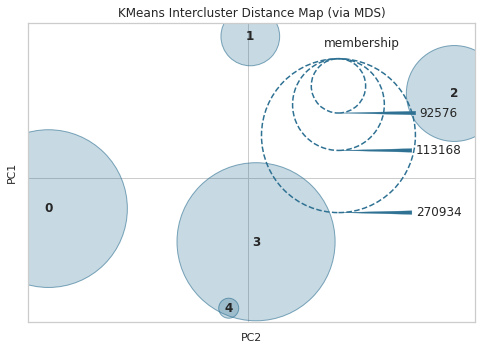

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [84]:
visualizer=InterclusterDistance(kmeanModel,  legend_loc='upper right',legend_size=3)

visualizer.fit(pca_df)
visualizer.show()

Our 5 cluster are sized by membership, the number 3 is the smallest one and also the most distant.

The ***dendrogram*** is a graphic rappresantation. It shows how groups that can be considered gradually they are formed according to the level of distance between the units considered. We can extract a sample to confirm the previous result.

In [85]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [86]:
pca_df_sample=pca_df.sample(10000)
norm_df_sample=norm_df.sample(10000)

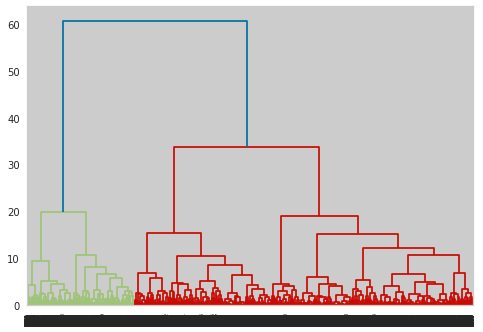

In [87]:
dend= dendrogram(linkage(pca_df_sample, method='ward'))

The result of the dendrogram is 2 clusers and this this the optimal number for us which will then be confirmed by the silhouette index.

It's time to use ***k-mean++*** algorithm. For doing that we will use  scikit-learn library. 

In [88]:
#instantiate the k-means class, using optimal number of clusters
optimal_kmeans = KMeans(init="k-means++", n_clusters=2, n_init=10, random_state=1)

#fit k-means algorithm to data
optimal_kmeans.fit(pca_df)


KMeans(n_clusters=2, random_state=1)

In [89]:
print("the centroids are: ", optimal_kmeans.cluster_centers_)

print("number ofiterations required to converge: ", optimal_kmeans.n_iter_)

print("the lowest SSE value is: ", optimal_kmeans.inertia_)

the centroids are:  [[-2.45240173e-01  1.05539604e-02 -4.36607733e-04 -2.39968677e-04
  -2.86983828e-04 -4.58308450e-04 -5.42221176e-05 -4.43071107e-05
  -1.33840576e-04]
 [ 7.54917157e-01 -3.24880123e-02  1.34399949e-03  7.38690033e-04
   8.83415686e-04  1.41080031e-03  1.66910692e-04  1.36389555e-04
   4.11998352e-04]]
number ofiterations required to converge:  3
the lowest SSE value is:  200686.99279253304


In [90]:
pca_df['cluster'] = optimal_kmeans.labels_
norm_df['cluster'] = optimal_kmeans.labels_

The main difference between kmean and kmans++ is the initialization of the centroids: in the first they are selected randomly, in the second the selection depends on a probabilistic rule. This technique speeds up convergence.

## 2.4 Analysing your results!

In the ***Characterizing Clusters*** we want to study the main characteristics of our clusters .\
For this analisys we have choosen the variables: n_transictions, ave_balance and cust_age

The next step is to categorise our variables in 4 categories.

In [91]:
labels = ["{0} - {1} ".format(i, i + 0.25) for i in np.arange(0.0, 1.0, 0.25)]

norm_df["T_group"] = pd.cut(norm_df.n_transactions, 4, right=False, labels=labels)

norm_df["B_group"] = pd.cut(norm_df.balance100000, 4, right=False, labels=labels)

norm_df["A_group"] = pd.cut(norm_df.cust_age, 4, right=False, labels=labels)

In [92]:
norm_df.head()

,n_transactions,common_gender,cust_age,balance100000,day_week,ave_month,lunch_time,dinner_time,older,birthday_amount,winter,richer_f,richer_m,percentage_t,mumbai_trans,cluster,T_group,B_group,A_group
0,0.2,0.0,0.130,0.333333,0.500000,0.727273,0.25,0.00,0.0,0.0,0.00,0.0,0.0,0.003045,0.000000,0,0.0 - 0.25,0.25 - 0.5,0.0 - 0.25
1,0.0,0.0,0.060,0.000000,1.000000,0.636364,0.00,0.25,0.0,0.0,0.00,0.0,0.0,0.000961,0.002070,0,0.0 - 0.25,0.0 - 0.25,0.0 - 0.25
2,0.2,0.0,0.125,0.333333,0.666667,0.272727,0.25,0.00,0.0,0.0,0.25,0.0,0.0,0.000772,0.001005,0,0.0 - 0.25,0.25 - 0.5,0.0 - 0.25
3,0.0,1.0,0.110,0.000000,0.500000,0.727273,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.000019,0.000000,1,0.0 - 0.25,0.0 - 0.25,0.0 - 0.25
4,0.0,0.0,0.350,0.000000,0.500000,0.636364,0.25,0.00,0.0,0.0,0.00,0.0,0.0,0.003205,0.000000,0,0.0 - 0.25,0.0 - 0.25,0.25 - 0.5


The following are the corrisponding ***pivot tables***, one for each varible.

In [93]:
table_trans = pd.pivot_table(norm_df,values=['n_transactions'], columns=['T_group'], index=['cluster'], fill_value=0)
table_trans

n_transactions                                    
T_group    0.0 - 0.25  0.25 - 0.5  0.5 - 0.75  0.75 - 1.0 
cluster                                                   
0             0.033751         0.4         0.6    0.810714
1             0.008631         0.4         0.6    0.800000

In [94]:
table_balance=pd.pivot_table(norm_df, values=['balance100000'] , columns=['B_group'], index=['cluster'], fill_value=0)
table_balance

balance100000                                    
B_group   0.0 - 0.25  0.25 - 0.5  0.5 - 0.75  0.75 - 1.0 
cluster                                                  
0                   0    0.333333    0.666667           1
1                   0    0.333333    0.666667           1

In [95]:
table_age = pd.pivot_table(norm_df, values=['cust_age'], columns=['A_group'], index=['cluster'], fill_value=0)
table_age

cust_age                                    
A_group 0.0 - 0.25  0.25 - 0.5  0.5 - 0.75  0.75 - 1.0 
cluster                                                
0          0.133453    0.315951    0.555463    0.933358
1          0.123859    0.324000    0.565424    0.957039

Pivot table with ***percentage***

In [96]:
lab= ["({0} - {1}) %".format(i, i + 0.25) for i in np.arange(0.0, 1.0, 0.25)]

norm_df["T_group%"] = pd.cut(norm_df.n_transactions, 4, right=False, labels=lab)

norm_df["B_group%"] = pd.cut(norm_df.balance100000, 4, right=False, labels=lab)

norm_df["A_group%"] = pd.cut(norm_df.cust_age, 4, right=False, labels=lab)

In [97]:
table_trans=pd.pivot_table(norm_df, values=['n_transactions'] , columns=['T_group%'], index=['cluster'], fill_value=0, aggfunc=len, margins=True)
table_trans_perc = table_trans.div( table_trans.iloc[:,-1], axis=0 )
table_trans_perc*100

n_transactions                                                    
T_group% (0.0 - 0.25) % (0.25 - 0.5) % (0.5 - 0.75) % (0.75 - 1.0) %    All
cluster                                                                    
0             97.559751       2.209882       0.212683       0.017684  100.0
1             99.852730       0.143382       0.002916       0.000972  100.0
All           98.121993       1.703173       0.161248       0.013586  100.0

In [98]:
table_balance=pd.pivot_table(norm_df, values=['balance100000'] , columns=['B_group%'], index=['cluster'], fill_value=0, aggfunc=len, margins=True)
table_balance_perc = table_balance.div( table_balance.iloc[:,-1], axis=0 )
table_balance_perc*100

balance100000                                                    
B_group% (0.0 - 0.25) % (0.25 - 0.5) % (0.5 - 0.75) % (0.75 - 1.0) %    All
cluster                                                                    
0             81.668369      17.720897       0.596839       0.013895  100.0
1             81.381717      18.453029       0.164768       0.000486  100.0
All           81.598082      17.900417       0.490894       0.010607  100.0

In [99]:
table_age=pd.pivot_table(norm_df, values=['cust_age'] , columns=['A_group%'], index=['cluster'], fill_value=0, aggfunc=len, margins=True)
table_age_perc = table_age.div( table_age.iloc[:,-1], axis=0 )
table_age_perc*100

cust_age                                                    
A_group% (0.0 - 0.25) % (0.25 - 0.5) % (0.5 - 0.75) % (0.75 - 1.0) %    All
cluster                                                                    
0             88.061648      11.277093       0.608839       0.052421  100.0
1             87.929660      11.194980       0.801481       0.073878  100.0
All           88.029284      11.256959       0.656075       0.057682  100.0

All the 3 variables are concentraded in the first quintile of the distribution. In fact the most values for each cluster are in the first class.

***Silhouette index*** is a measure to evaluate the goodness of the partition. It assumes values ​​in the interval [0,1]. 

- s(i) = 1 means that unit i is correctly assigned to the cluster
- s(i) = -1  means that unit i is not assigned to the right cluster
- s(i) = 0 means that the unit i is not clearly assignable to one
of the two clusters.

Differenty from the previous rappresentation this index is calculated using the mean intra-cluster distance.

In [100]:
from yellowbrick.cluster import SilhouetteVisualizer

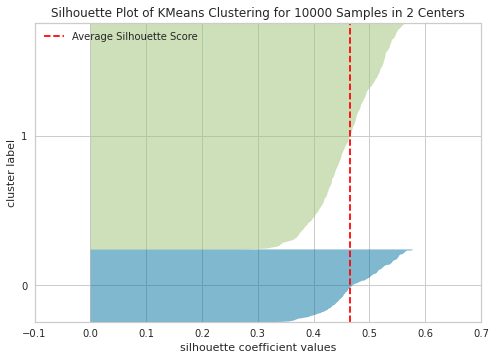

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 10000 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [101]:
model=KMeans(2, random_state=42)
visualizer=SilhouetteVisualizer(model,colors='yellowbrick')

visualizer.fit(pca_df_sample)
visualizer.show()

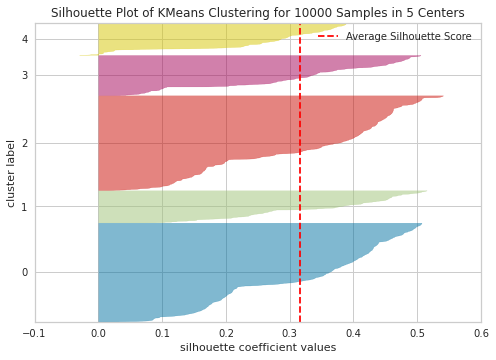

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 10000 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [102]:
model=KMeans(5, random_state=42)
visualizer=SilhouetteVisualizer(model,colors='yellowbrick')

visualizer.fit(pca_df_sample)
visualizer.show()

From these plots we can assume that the best silhouette index is 0.47 with the optimal number of clusters equal to 2, so we can say that most of the units are assigned correctly.\
So the dendrogram show the right number of clusters.

## Bonus Question

 ***Density-Based Spatial Clustering of Applications with Noise*** it's a density-based clustering algorithm. It defines a cluster as a maximum set of density-connected points because the main idea is improves regions with adequately high density into clusters. From this idea is clear that the number of cluster in a big set of data will be high. Differently from k means that analyze all the object, DBSCAN discards objects that it defines as noise. Another main difference is that K-means algorithm consider all clusters come from a Gaussian distributions with several means but the equal covariance matrix. DIISCAN creates no assumption about the distribution of the record.

In [103]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

db = DBSCAN(eps=0.3).fit(pca_df_sample)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 12
Estimated number of noise points: 95


***Hierarchical methods*** can be either divisive or agglomerative. We choose the ***agglomerative*** one. It begin with n clusters and sequentially combine similar clusters until only one cluster is obtained. In the K Means, that starts with random choice of clusters, the results produced by running the algorithm many times may differ, instead results are reproducible in Hierarchical clustering. Another difference is that in the k mean th convergence is guaranteed and it can be apply in big dataset, on the contrary the agglomerative method requires the computation and storage of an n×n  distance matrix that can be expensive for very large datasets, in fact we have used a sample. The also for the agglomerative method the number of clusters is 2.

In [104]:
from sklearn.cluster import AgglomerativeClustering

clust = AgglomerativeClustering().fit(pca_df_sample)
print("the number of clusers is: ", clust.n_clusters_)

the number of clusers is:  2


## Command Line Question

In [40]:
%%sh
sh CommandLine_HW4.sh


1. Which location has the maximum number of purchases been made?  103595 purchases made in MUMBAI

2. In the dataset provided, did females spend more than males, or vice versa? 

	 F = 4.85254e+08     M = 1.23285e+09   →  Males spended more 

3. Report the customer with the highest average transaction amount in the dataset: 

    CustomerID : C7319271 with average transaction amount = 1.56003e+06 
 


In [41]:
cat CommandLine_HW4.sh

#!/bin/sh

q1="Which location has the maximum number of purchases been made?"

variable=$(cut -f5 -d, bank_transactions.csv | sort | uniq -c | sort -k1 -n  | tail -1)

echo -e "\n1. $q1 ${variable[0]:0:7} purchases made in ${variable[0]:8:13}"

q2="In the dataset provided, did females spend more than males, or vice versa?"

output=$(cut -f4,9 -d, bank_transactions.csv |awk 'NR!=1'| awk -F, '$1!=""'| awk -F, '{col[$1]+=$2} END {for (i in col) print i" = "col[i]}' | sort -g)

echo -e "\n2. $q2 \n" 
echo -e "\t ${output[0]:0:15}     ${output[0]:16:15}   →  Males spended more \n"

q3="Report the customer with the highest average transaction amount in the dataset:"

result=$(cut -f2,9 -d, bank_transactions.csv | awk -F, '{col[$1]+=$2; count[$1]++} END {for (x in col) print x, col[x]/count[x]}' | sort -g -k2 | tail -1)

echo -e "3. $q3 \n
    CustomerID : ${result[0]:0:8} with average transaction amount = ${result[0]:9:11} \n "







